In [1]:
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from fastkde import fastkde
from sklearn.ensemble import RandomForestClassifier


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

#### This code should not be run again. It was used to subset the original data.

In [2]:
# importing train data
train = pd.read_csv('data/train.csv')
train

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,527987,0,2,1,8,0,0,0,0,0,...,3,1,1,7,1,1,0,1,0,0
1,47519,0,3,1,3,0,0,1,0,0,...,3,2,3,5,0,0,1,1,1,1
2,938513,0,1,1,1,0,0,1,0,0,...,1,1,1,4,0,1,1,0,0,1
3,279774,0,0,1,2,0,0,1,0,0,...,6,0,5,3,0,1,1,0,0,0
4,232653,0,3,1,2,1,0,0,1,0,...,4,0,5,11,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59516,1207113,1,1,1,7,0,4,0,0,1,...,3,1,1,9,0,0,1,0,1,0
59517,1212728,1,0,1,5,0,0,0,1,0,...,6,2,1,2,0,1,1,0,0,0
59518,757821,1,3,1,7,0,1,1,0,0,...,3,1,3,8,0,0,0,1,0,0
59519,875118,1,0,3,5,1,0,0,1,0,...,7,2,4,6,0,1,1,0,0,0


In [3]:
##subsetting the train data to only be 10% of each class and saving it over the original data
#subset_train = train.groupby('target').sample(frac=0.1)
#subset_train['target'].value_counts()
#subset_train.to_csv('data/train.csv', index=False)
#subset_train

### Setting Up
Loading data, setting X and y, and defining a cross validation function that can be used for all methods.

In [4]:
train = pd.read_csv('data/train.csv', header = 0)

x = train.drop(columns=['target', 'id'])
y = train['target']

In [5]:
def crossvalidate(kf, x, y, model):
    cm_list = []
    accuracy = []
    recall = []
    for train_index, test_index in kf.split(x, y):
        xtrain, xtest = x[train_index], x[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        model.fit(xtrain, ytrain)
        y_pred = model.predict(xtest)
        accuracy.append(accuracy_score(ytest, y_pred))
        recall.append(recall_score(ytest, y_pred, average = 'binary'))
        cm_list.append(confusion_matrix(ytest, y_pred))
    return cm_list, accuracy, recall

### Data Examination
Graph showing number of samples in each class in the original data

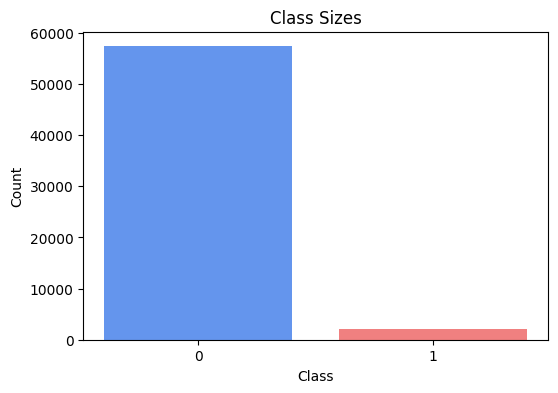

In [6]:
class_counts = y.value_counts()

# Plotting the class sizes
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values, color=['cornflowerblue', 'lightcoral'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Sizes")
plt.xticks(class_counts.index)
plt.show()

## Synthetic Minority Oversampling

In [7]:
oversample = SMOTE()
x_sampled, y_sampled = oversample.fit_resample(x, y)
counter = Counter(y_sampled)

In [8]:
model = KNeighborsClassifier()
kf = StratifiedKFold(n_splits = 5)
scaler = StandardScaler()
x_sampled = scaler.fit_transform(x_sampled)
cm_list, accuracy, recall = crossvalidate(kf, x_sampled, y_sampled, model)

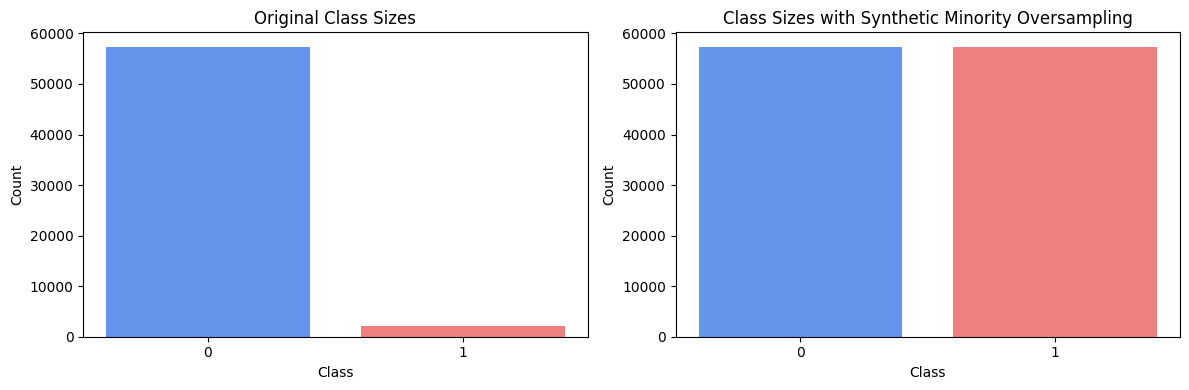

In [9]:
# Creating subplots for side-by-side graphs
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plotting original class size graph
class_counts = y.value_counts()
axs[0].bar(class_counts.index, class_counts.values, color=['cornflowerblue', 'lightcoral'])
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Count")
axs[0].set_title("Original Class Sizes")
axs[0].set_xticks(class_counts.index)

# Plotting updated class size with SMOTE
class_counts_sampled = y_sampled.value_counts()
axs[1].bar(class_counts_sampled.index, class_counts_sampled.values, color=['cornflowerblue', 'lightcoral'])
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Count")
axs[1].set_title("Class Sizes with Synthetic Minority Oversampling")
axs[1].set_xticks(class_counts_sampled.index)

plt.tight_layout()
plt.show()

In [10]:
# Printing overall results
print("Overall Results:")
print(f"Accuracy: {np.mean(accuracy)}")
print(f"Recall for Minority Class: {np.mean(recall)}")
print("Confusion Matrix (average across folds):\n", np.mean(cm_list, axis=0))

# Display results for each fold
for fold, cm in enumerate(cm_list, 1):
    print(f"\nFold {fold} Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy[fold - 1]}")
    print(f"Recall for Minority Class: {recall[fold - 1]}")

Overall Results:
Accuracy: 0.8887310072952767
Recall for Minority Class: 0.9993374019180472
Confusion Matrix (average across folds):
 [[8.92540e+03 2.54500e+03]
 [7.60000e+00 1.14628e+04]]

Fold 1 Confusion Matrix:
[[ 8829  2642]
 [   38 11432]]
Accuracy: 0.8831785885532453
Recall for Minority Class: 0.9966870095902354

Fold 2 Confusion Matrix:
[[ 8954  2517]
 [    0 11470]]
Accuracy: 0.8902837714136262
Recall for Minority Class: 1.0

Fold 3 Confusion Matrix:
[[ 8941  2529]
 [    0 11471]]
Accuracy: 0.8897606904668497
Recall for Minority Class: 1.0

Fold 4 Confusion Matrix:
[[ 8952  2518]
 [    0 11471]]
Accuracy: 0.8902401813347283
Recall for Minority Class: 1.0

Fold 5 Confusion Matrix:
[[ 8951  2519]
 [    0 11470]]
Accuracy: 0.8901918047079337
Recall for Minority Class: 1.0


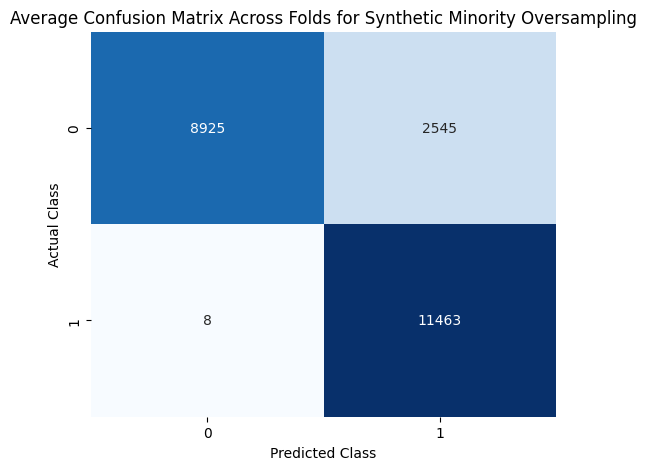

In [11]:
# visualizing overall heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(np.mean(cm_list, axis=0), annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.title("Average Confusion Matrix Across Folds for Synthetic Minority Oversampling")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

## ADASYN with FastKDE

In [12]:
# converting X and y to numpy arrays
X = np.array(x) 
y = np.array(y) 

# applying FastKDE to the feature data to smooth and estimate the density
num_points = 257  # setting number of points for KDE
var_names = [f'feature_{i}' for i in range(X.shape[1])]  # assigning names to each feature

# calculating the pdf for each feature in the data, the density estimation for each feature is stored in kde_result
kde_result = {}
for i in range(X.shape[1]):
    kde_result[f'feature_{i}'] = fastkde.pdf(X[:, i], var_names=[var_names[i]], num_points=num_points)

# using ADASYN to generate synthetic data to balance the data
adasyn = ADASYN(sampling_strategy='minority', n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# splitting the resampled data using stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True)

# creating the RandomForest model
model = RandomForestClassifier()  # performs better than KNN

# calling the crossvalidate function with the resampled data
cm_list, accuracy, recall = crossvalidate(skf, X_resampled, y_resampled, model)

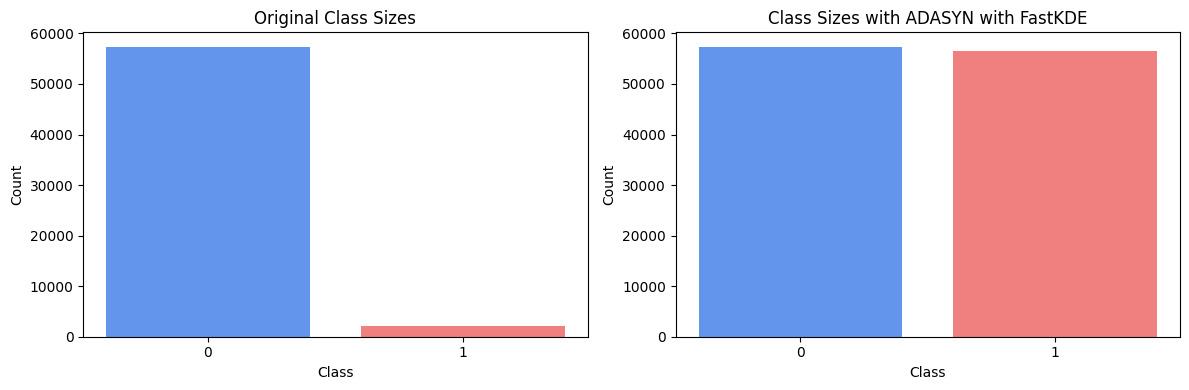

In [13]:
# converting back to pandas series for plotting
y = train['target']
y_resampled = series = pd.Series(y_resampled, name='class_label')

# Creating subplots for side-by-side display
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plotting original class size graph
class_counts = y.value_counts()
axs[0].bar(class_counts.index, class_counts.values, color=['cornflowerblue', 'lightcoral'])
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Count")
axs[0].set_title("Original Class Sizes")
axs[0].set_xticks(class_counts.index)

# Plotting updated class size with SMOTE
class_counts_sampled = y_resampled.value_counts()
axs[1].bar(class_counts_sampled.index, class_counts_sampled.values, color=['cornflowerblue', 'lightcoral'])
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Count")
axs[1].set_title("Class Sizes with ADASYN with FastKDE")
axs[1].set_xticks(class_counts_sampled.index)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [14]:
# Printing overall results
print("Overall Results:")
print(f"Accuracy: {np.mean(accuracy)}")
print(f"Recall for Minority Class: {np.mean(recall)}")
print("Confusion Matrix (average across folds):\n", np.mean(cm_list, axis=0))

# Display results for each fold
for fold, cm in enumerate(cm_list, 1):
    print(f"\nFold {fold} Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy[fold - 1]}")
    print(f"Recall for Minority Class: {recall[fold - 1]}")

Overall Results:
Accuracy: 0.9808674254075669
Recall for Minority Class: 0.9614232928782037
Confusion Matrix (average across folds):
 [[11470.4     0. ]
 [  435.4 10851.2]]

Fold 1 Confusion Matrix:
[[11471     0]
 [  430 10856]]
Accuracy: 0.9811047150327372
Recall for Minority Class: 0.961899698741804

Fold 2 Confusion Matrix:
[[11471     0]
 [  433 10853]]
Accuracy: 0.9809728874631981
Recall for Minority Class: 0.9616338826865143

Fold 3 Confusion Matrix:
[[11470     0]
 [  457 10830]]
Accuracy: 0.9799182669068858
Recall for Minority Class: 0.9595109417914415

Fold 4 Confusion Matrix:
[[11470     0]
 [  429 10858]]
Accuracy: 0.9811486575559168
Recall for Minority Class: 0.9619916718348542

Fold 5 Confusion Matrix:
[[11470     0]
 [  428 10859]]
Accuracy: 0.9811926000790966
Recall for Minority Class: 0.9620802693364047


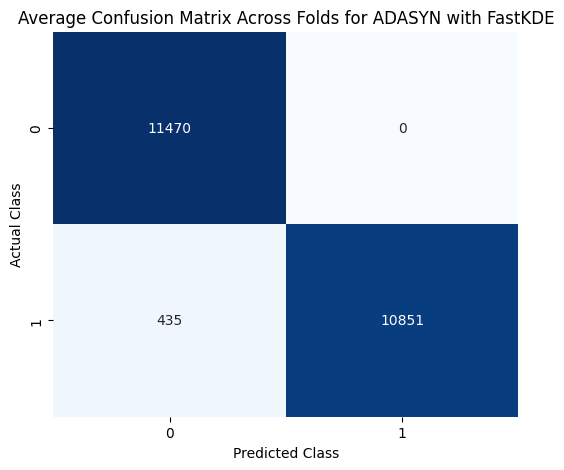

In [15]:
# visualizing overall heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(np.mean(cm_list, axis=0), annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.title("Average Confusion Matrix Across Folds for ADASYN with FastKDE")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

## Normalizing Flows

In [16]:
# reimporting data to ensure original dataset is used
train = pd.read_csv('data/train.csv', header = 0)

X = train.drop(columns=['target', 'id'])
y = train['target']

In [17]:
# defining the normalizing flow mode
class SimpleFlow(nn.Module):
    # Initialize the model with input dimensions and hidden layer size
    def __init__(self, input_dim, hidden_dim):
        super(SimpleFlow, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # defining a fully connected layer that maps from input dim to hidden dim
        self.fc2 = nn.Linear(hidden_dim, input_dim) # defining a second fully connected layer that also maps from input to hidden dim
        
    # defining the forward pass of the model
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # applying first layer
        x = self.fc2(x)   # applying second layer
        # returning transformed input
        return x

    # defining a method to generate synthetic samples using the trained flow
    def generate_samples(self, n_samples):
        # generating random noise (z) with a normal distribution
        z = torch.randn(n_samples, self.fc1.in_features)  
        # using the flow model to transform the noise into synthetic samples
        return self.forward(z)

In [18]:
def generate_minority_samples(X_minority, n_samples):
    n_samples = max(0, n_samples)  # prevents negative sample generation

    # if no samples need to be generated, return empty array with same number of features as X_minority
    if n_samples == 0:
        return np.empty((0, X_minority.shape[1]))  
    
    # converting X minority to NumPy array 
    X_minority_np = X_minority.values
    
    # getting the number of input features from the minority class dataset
    input_dim = X_minority_np.shape[1]
    
    # instantiting the SimpleFlow class
    flow = SimpleFlow(input_dim, hidden_dim=64)
    
    # defining the optimizer and the loss function 
    optimizer = torch.optim.Adam(flow.parameters(), lr=0.001) 
    loss_fn = nn.MSELoss() 
    
    # converting minority class data into a PyTorch tensor
    X_tensor = torch.tensor(X_minority_np, dtype=torch.float32) 
    
    # training the model on the minority class data
    for epoch in range(200):  # training the model for 200 epochs 
        optimizer.zero_grad()  # resetting gradients before each backward pass
        output = flow(X_tensor)  # passing the minority class data through the flow model to get predictions
        loss = loss_fn(output, X_tensor)  # calculating the loss between predicted output and actual data
        loss.backward()  # backpropogating loss to update model weights
        optimizer.step()  # updating the model's weights

    # generating synthetic samples after training the model as numpy arrays
    synthetic_samples = flow.generate_samples(n_samples).detach().numpy()  
    return synthetic_samples 

In [19]:
# separating the minority class
class_counts = y.value_counts()
minority_class = class_counts.index[-1]
majority_class = class_counts.index[0]
X_minority = X[y == minority_class]
X_majority = X[y == majority_class]

# generating synthetic samples so minority class matches majority class size
n_minority_to_generate = X_majority.shape[0] - X_minority.shape[0]
synthetic_samples = generate_minority_samples(X_minority, n_minority_to_generate)

# combining synthetic samples with original data
X_balanced = np.vstack([X.values, synthetic_samples])
y_balanced = np.hstack([y.values, np.full(synthetic_samples.shape[0], minority_class)])

# stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True)

# initializing RandomForestClassifier
model = RandomForestClassifier()

# perforing cross-validation
cm_list, accuracy, recall = crossvalidate(skf, X_balanced, y_balanced, model)

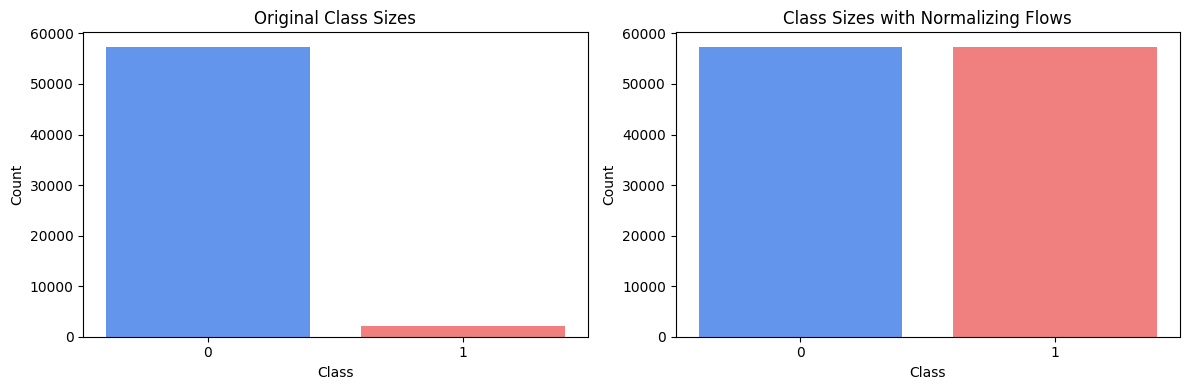

In [20]:
y_balanced = series = pd.Series(y_balanced, name='class_label')

# Creating subplots for side-by-side display
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plotting original class size graph
class_counts = y.value_counts()
axs[0].bar(class_counts.index, class_counts.values, color=['cornflowerblue', 'lightcoral'])
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Count")
axs[0].set_title("Original Class Sizes")
axs[0].set_xticks(class_counts.index)

# Plotting updated class size with SMOTE
class_counts_sampled = y_balanced.value_counts()
axs[1].bar(class_counts_sampled.index, class_counts_sampled.values, color=['cornflowerblue', 'lightcoral'])
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Count")
axs[1].set_title("Class Sizes with Normalizing Flows")
axs[1].set_xticks(class_counts_sampled.index)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [21]:
# printing overall results
print("Overall Results:")
print(f"Accuracy: {np.mean(accuracy)}")
print(f"Recall for Minority Class: {np.mean(recall)}")
print("Confusion Matrix (average across folds):\n", np.mean(cm_list, axis=0))

# printing results for each fold
for fold, cm in enumerate(cm_list, 1):
    print(f"\nFold {fold} Confusion Matrix:\n{cm}")
    print(f"Accuracy: {accuracy[fold - 1]}")
    print(f"Recall for Minority Class: {recall[fold - 1]}")

Overall Results:
Accuracy: 0.981081742342958
Recall for Minority Class: 0.9621809153395959
Confusion Matrix (average across folds):
 [[1.14702e+04 2.00000e-01]
 [4.33800e+02 1.10366e+04]]

Fold 1 Confusion Matrix:
[[11471     0]
 [  423 11047]]
Accuracy: 0.9815613966261278
Recall for Minority Class: 0.9631211857018309

Fold 2 Confusion Matrix:
[[11471     0]
 [  450 11020]]
Accuracy: 0.9803844644958808
Recall for Minority Class: 0.960767218831735

Fold 3 Confusion Matrix:
[[11469     1]
 [  444 11027]]
Accuracy: 0.9806024148903709
Recall for Minority Class: 0.9612936971493331

Fold 4 Confusion Matrix:
[[11470     0]
 [  422 11049]]
Accuracy: 0.9816049867050259
Recall for Minority Class: 0.9632115770203121

Fold 5 Confusion Matrix:
[[11470     0]
 [  430 11040]]
Accuracy: 0.9812554489973845
Recall for Minority Class: 0.962510897994769


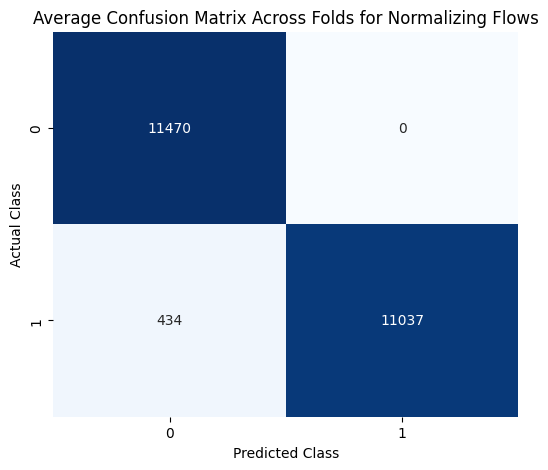

In [22]:
# visualizing overall heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(np.mean(cm_list, axis=0), annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.title("Average Confusion Matrix Across Folds for Normalizing Flows")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()